# Starbucks Capstone Challenge
## Introduction
This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

# Data Sets
The data is contained in three files:

- portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
- profile.json - demographic data for each customer
- transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**

- id (string) - offer id
- offer_type (string) - type of offer ie BOGO, discount, informational
- difficulty (int) - minimum required spend to complete an offer
- reward (int) - reward given for completing an offer
- duration (int) - time for offer to be open, in days
- channels (list of strings)

**profile.json**

- age (int) - age of the customer
- became_member_on (int) - date when customer created an app account
- gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
- id (str) - customer id
- income (float) - customer's income

**transcript.json**

- event (str) - record description (ie transaction, offer received, offer viewed, etc.)
- person (str) - customer id
- time (int) - time in hours since start of test. The data begins at time t=0
- value - (dict of strings) - either an offer id or transaction amount depending on the record

# Packages Used

In [1979]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer, LabelEncoder
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression 
from sklearn import datasets, svm, metrics


In [1980]:
# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

# Exloratory Data Analysis
- ## Portfolio Data

In [1981]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [1982]:
portfolio.shape # 10 rows and 6 columns

(10, 6)

In [1983]:
# Statistics
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [1984]:
# Different types of offer
list(portfolio.offer_type.unique())

['bogo', 'informational', 'discount']

In [1985]:
# Number of the various offer types
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

- ## Profile Data

In [1986]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [1987]:
# Statistics
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [1988]:
# Number of youngest customers
profile[profile['age'] == profile['age'].min()].shape[0]

70

In [1989]:
# Number of oldest customers
profile[profile['age'] == profile['age'].max()].shape[0]

2175

In [1990]:
# Number of missing values by columns
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [1991]:
# Number of customers by gender. 'O' means 'None'
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [1992]:
# Number of duplicate records
profile.duplicated(subset=None, keep='first').count()

17000

In [1993]:
# Number of missinig income values
(profile.income.isnull() == True).sum()

2175

In [1994]:
# Number of genders that are neither Male or Female
(profile.gender == 'O').sum()

212

In [1995]:
# Number of customers aged 118
(profile.age == 118).sum()

2175

- ## Transcript Data

In [1996]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [1997]:
# Statistics
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [1998]:
# Unique events
list(transcript.event.unique())

['offer received', 'offer viewed', 'transaction', 'offer completed']

In [1999]:
# Number of events per category
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [2000]:
# Number of missing values by column
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

**From the above data analyses, StarBucks offers 3 promotions namely, 'bogo', 'informational' and 'discount'. The number of oldest customers are aged 118 and are 2175 in number. This is the same number with the number of absent incomes. It is therefore possible that these are non-existent customers. The youngest customers are aged 18. The different unique events are 'offer received', 'offer viewed', 'transaction' and 'offer completed'. Finally, there are no missing values in the transcript data.**

## Data Visualization

<AxesSubplot:title={'center':'Offer Types'}, xlabel='offer_type', ylabel='count'>

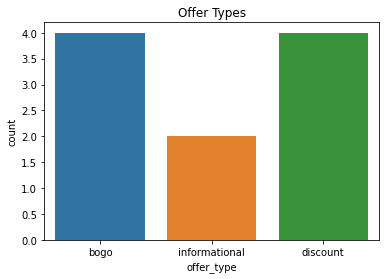

In [2001]:
# Offer types
plt.title('Offer Types')
sns.countplot(x='offer_type', data=portfolio)

<AxesSubplot:title={'center':'Customers By Gender'}, xlabel='gender', ylabel='count'>

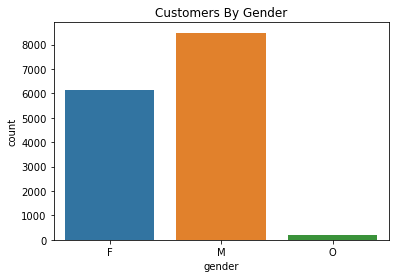

In [2002]:
# Customers by gender

plt.title('Customers By Gender')
sns.countplot(x='gender', data=profile)

<AxesSubplot:title={'center':'The Various Events'}, xlabel='Events', ylabel='Count'>

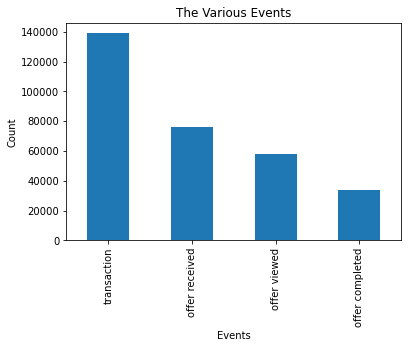

In [2003]:
# Number of events
plt.title('The Various Events')
plt.xlabel('Events')
plt.ylabel('Count')
events = transcript.event.value_counts()
events.plot(kind='bar')

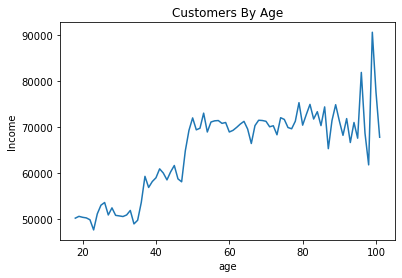

In [2004]:
# Income based on age
plt.title('Customers By Age')
plt.ylabel('Income')
profile.groupby(['age'])['income'].mean().plot(kind='line');

# Data Preprocessing

- ## Portfolio

In [2005]:
# The portfolio dataframe once again
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [2006]:
# Encode the 'channels' column
channels_df = pd.DataFrame(MultiLabelBinarizer().fit_transform(portfolio.channels), columns=[
    'email', 'mobile', 'social', 'web'])
channels_df

,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1
5,1,1,1,1
6,1,1,1,1
7,1,1,1,0
8,1,1,1,1
9,1,1,0,1


In [2007]:
# Concatenate the portfolio dataframe with the encoded channels dataframe
port_concat = pd.concat([portfolio, channels_df], axis=1)
port_concat

,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [2008]:
# Pass the concatenated dataframe to another variable (port_concat1) to avoid changing it
port_concat1 = port_concat
port_concat1

,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [2009]:
# Assign values to the various offer types
def offer_col(col):
    if col[-1] == 'o':
        return 1
    elif col[-1] == 't':
        return 2
    elif col[-1] == 'l':
        return 3

for offers in port_concat['offer_type']:
    port_concat['offer_type_value'] = port_concat['offer_type'].apply(offer_col)
    
port_concat

,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web,offer_type_value
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,3
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,2
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,2
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,3
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,2


- ## Profile

In [2010]:
# View the profile dataframe once more
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [2011]:
# Format the dates in 'become_member_on' column
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [2012]:
# Convert the age 118 to something more useful
profile['age'].replace(118, np.nan, inplace=True) # Replace age 118 with NaN
profile['age']= np.around(profile['age'].fillna(profile['age'].mean())) # Fill the NaNs with the mean of the ages
profile.head()

,gender,age,id,became_member_on,income
0,None,54.0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,54.0,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,54.0,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [2013]:
 # Similarly fill the NaN values of the income with the mean value

profile['income'] = np.around(profile['income'].fillna(profile['income'].mean()), decimals=2)
profile.head()

,gender,age,id,became_member_on,income
0,None,54.0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.99
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.00
2,None,54.0,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,65404.99
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.00
4,None,54.0,a03223e636434f42ac4c3df47e8bac43,2017-08-04,65404.99


In [2014]:
# Similarly fill the NaN values of the gender column with the mode value

profile['gender'] = profile['gender'].fillna(profile['gender'].mode()[0])
profile.head()

,gender,age,id,became_member_on,income
0,M,54.0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.99
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.00
2,M,54.0,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,65404.99
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.00
4,M,54.0,a03223e636434f42ac4c3df47e8bac43,2017-08-04,65404.99


In [2015]:
profile1 = profile

In [2016]:
# View the highest ages
profile1 = profile1.sort_values(by=['age'], axis=0, ascending=False)
profile1.head(10)

,gender,age,id,became_member_on,income
14846,F,101.0,e0ea90ddd2f147e082d21e97f51ec1b1,2017-11-09,56000.0
15800,F,101.0,047ad0135cfe4c0ea5ba019da4de9c52,2017-03-09,59000.0
4100,F,101.0,d2fdc2be8ab64e4ba04830d441e53fd5,2015-05-26,99000.0
16864,F,101.0,1593d617fac246ef8e50dbb0ffd77f5f,2017-11-27,82000.0
1556,F,101.0,4d2ccfcbbebf4bd9baf4b7e433d0e288,2017-10-04,43000.0
6061,F,100.0,9b675a966bd040eeac75f9aa01b14773,2018-04-10,70000.0
1171,F,100.0,28bbebb2b76f4057b1115dd80441e37a,2017-09-05,118000.0
15724,M,100.0,97d7120a2a154a6d98b053e64b782ecf,2015-10-13,63000.0
6902,F,100.0,85f4e5ea5c0044619482bfe16ae32c01,2017-12-31,71000.0
16749,F,100.0,9a30ad4712a341e5be025cf0f96d7ee3,2017-10-19,42000.0


In [2017]:
# Assign values to the various gender groups

def gender_val(val):
    if val == 'M':
        return 1
    elif val == 'F':
        return 2
    else:
        return 3
    

for genders in profile['gender']:
    profile['gender_value'] = profile['gender'].apply(gender_val)
    
profile.head()

,gender,age,id,became_member_on,income,gender_value
0,M,54.0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.99,1
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.00,2
2,M,54.0,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,65404.99,1
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.00,2
4,M,54.0,a03223e636434f42ac4c3df47e8bac43,2017-08-04,65404.99,1


In [2018]:
# Assign age ranges and corresponding values
def age_col(val):
    if val <= 20:
        return 'Below 21'
    elif (val >= 21) and (val <= 40):
        return '21-40'
    elif (val >= 41) and (val <= 60):
        return '41-60'
    elif (val >= 61) and (val <= 80):
        return '61-80'
    else:
        return 'Above 80'

def age_val(val):
    if val <= 20:
        return 1
    elif (val >= 21) and (val <= 40):
        return 2
    elif (val >= 41) and (val <= 60):
        return 3
    elif (val >= 61) and (val <= 80):
        return 4
    else:
        return 5

for ages in profile['age']:
    profile['age_range'] = profile['age'].apply(age_col)
    profile['age_range_value'] = profile['age'].apply(age_val)
    
profile.head()

,gender,age,id,became_member_on,income,gender_value,age_range,age_range_value
0,M,54.0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.99,1,41-60,3
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.00,2,41-60,3
2,M,54.0,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,65404.99,1,41-60,3
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.00,2,61-80,4
4,M,54.0,a03223e636434f42ac4c3df47e8bac43,2017-08-04,65404.99,1,41-60,3


In [2019]:
# Assign income ranges and corresponding values
# From the statistics of the profile dataframe:
# Minimum income = 30000
# Maximum income = 120000

def income_col(val):
    if (val >= 30000) and (val <= 50000):
        return '30-50'
    elif (val >= 50001) and (val <= 70000):
        return '51-70'
    elif (val >= 70001) and (val <= 90000):
        return '71-90'
    elif (val >= 90001) and (val <= 110000):
        return '91-110'
    else:
        return 'Above 110'

def income_val(val):
    if (val >= 30000) and (val <= 50000):
        return 1
    elif (val >= 50001) and (val <= 70000):
        return 2
    elif (val >= 70001) and (val <= 90000):
        return 3
    elif (val >= 90001) and (val <= 110000):
        return 4
    else:
        return 4

for incomes in profile['income']:
    profile['income_range'] = profile['income'].apply(income_col)
    profile['inc_range_value'] = profile['income'].apply(income_val)
    
profile.head()

,gender,age,id,became_member_on,income,gender_value,age_range,age_range_value,income_range,inc_range_value
0,M,54.0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.99,1,41-60,3,51-70,2
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.00,2,41-60,3,Above 110,4
2,M,54.0,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,65404.99,1,41-60,3,51-70,2
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.00,2,61-80,4,91-110,4
4,M,54.0,a03223e636434f42ac4c3df47e8bac43,2017-08-04,65404.99,1,41-60,3,51-70,2


- ## Transcript

In [2020]:
# View the transcript dataframe once again
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [2021]:
# Pass the transcript dataframe to a new variable - transcript1
transcript1 = transcript

In [2022]:
# Reframing the value column to see its quantities
val_key = lambda x: str(list(x.keys()))
col_val_key = transcript['value'].apply(val_key)
new_val_col = pd.crosstab(col_val_key, transcript['event'])
new_val_col

event,offer completed,offer received,offer viewed,transaction
value,,,,
['amount'],0,0,0,138953
['offer id'],0,76277,57725,0
"['offer_id', 'reward']",33579,0,0,0


In [2023]:
# Create dummies for event column
event_dum = pd.get_dummies(transcript1['event'])


In [2024]:
# Concatenate event_dum with the transcript dataframe
transcript1 = pd.concat([transcript1, event_dum], axis=1)
transcript1.head()

,person,event,value,time,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0,0


In [2025]:
# Unique keys of the dictionaries of the 'value column'
val_set = []
for vals in transcript1['value']:
    for v in vals.keys():
        val_set.append(v)
print(set(val_set))

{'offer id', 'offer_id', 'amount', 'reward'}


In [2026]:
# Create 'offer' column with the values of the dictionary of value column
transcript1['id'] = [[*offers.values()][0]if [*offers.keys()][0] in ['offer id','offer_id'] else None for offers in transcript1.value]

# Create 'expended' column with the rounded value of the values of the dictionary of the value column
transcript1['expended'] = [np.around([*offers.values()][0], decimals=3)if [*offers.keys()][0] == 'amount' else None for offers in transcript1.value]

transcript1.head()

,person,event,value,time,offer completed,offer received,offer viewed,transaction,id,expended
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [2027]:
# Now that the transcript dataframe has got an 'id' column, let the 'id' columns of the 3 dataframes be viewed.

# Unique ids of the profile dataframe
portfolio.id.unique()

array(['ae264e3637204a6fb9bb56bc8210ddfd',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '3f207df678b143eea3cee63160fa8bed',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '5a8bc65990b245e5a138643cd4eb9837',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2906b810c7d4411798c6938adc9daaa5'], dtype=object)

In [2028]:
# Unique ids of the profile dataframe
profile.id.nunique()

17000

In [2029]:
transcript1.id.unique()

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '3f207df678b143eea3cee63160fa8bed',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       '5a8bc65990b245e5a138643cd4eb9837', None], dtype=object)

In [2030]:
# It can be seen that the port_concat and transactions id columns have the same content
# Change the 'ids' to 'offer_id' and merge both dataframes on 'offer_id' column

port_concat = port_concat.rename(columns={'id': 'offer_id'})
transcript1 = transcript1.rename(columns={'id': 'offer_id'})

port_trans = pd.merge(port_concat, transcript1, on='offer_id')
port_trans.head()

,reward,channels,difficulty,duration,offer_type,offer_id,email,mobile,social,web,offer_type_value,person,event,value,time,offer completed,offer received,offer viewed,transaction,expended
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,4b0da7e80e5945209a1fdddfe813dbe0,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,0,1,0,0,NaN
1,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,1e9420836d554513ab90eba98552d0a9,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,0,1,0,0,NaN
2,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,02c083884c7d45b39cc68e1314fec56c,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,0,1,0,0,NaN
3,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,676506bad68e4161b9bbaffeb039626b,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,0,1,0,0,NaN
4,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,fe8264108d5b4f198453bbb1fa7ca6c9,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,0,1,0,0,NaN


In [2037]:
port_trans.columns

Index(['reward', 'channels', 'difficulty', 'duration', 'offer_type',
       'offer_id', 'email', 'mobile', 'social', 'web', 'offer_type_value',
       'customer_id', 'event', 'value', 'time', 'offer completed',
       'offer received', 'offer viewed', 'transaction', 'expended'],
      dtype='object')

In [2033]:
# Change the 'id' column of the profile dataframe to 'customer_id' 
profile1 = profile.rename(columns={'id': 'customer_id'})

# Also change the 'person' column of the port_trans dataframe to 'customer_id'
port_trans = port_trans.rename(columns={'person': 'customer_id'})

In [2035]:
# Merge the port_trans and profile 

port_trans_prof = pd.merge(port_trans, profile1, on='customer_id')
port_trans_prof.head()

,reward,channels,difficulty,duration,offer_type,offer_id,email,mobile,social,web,...,expended,gender,age,became_member_on,income,gender_value,age_range,age_range_value,income_range,inc_range_value
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,...,NaN,M,64.0,2017-09-09,100000.0,1,61-80,4,91-110,4
1,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,...,NaN,M,64.0,2017-09-09,100000.0,1,61-80,4,91-110,4
2,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,...,NaN,M,64.0,2017-09-09,100000.0,1,61-80,4,91-110,4
3,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,...,NaN,M,64.0,2017-09-09,100000.0,1,61-80,4,91-110,4
4,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,...,NaN,M,64.0,2017-09-09,100000.0,1,61-80,4,91-110,4


In [2038]:
port_trans_prof.columns

Index(['reward', 'channels', 'difficulty', 'duration', 'offer_type',
       'offer_id', 'email', 'mobile', 'social', 'web', 'offer_type_value',
       'customer_id', 'event', 'value', 'time', 'offer completed',
       'offer received', 'offer viewed', 'transaction', 'expended', 'gender',
       'age', 'became_member_on', 'income', 'gender_value', 'age_range',
       'age_range_value', 'income_range', 'inc_range_value'],
      dtype='object')